In [1]:
import numpy             as np
import pandas            as pd

from utils import (
    Adblocker,
    compare_CDF,
    barplot,
    pieplot,
    get_99p,
    generate_table
)

In [2]:
brave    = Adblocker(filename='data/brave_timings.json', color='#ff5500', label='Brave')
ghostery = Adblocker(filename='data/ghostery_timings.json', color='#00aff0', label='Ghostery')
ublock   = Adblocker(filename='data/ublock_timings.json', color='#800000', label='uBlock Origin')
duck     = Adblocker(filename='data/duckduckgo_timings.json', color='#58b792', label='DuckDuckGo')
abp      = Adblocker(filename='data/adblockplus_timings.json', color='#c70d2c', label='Adblock Plus')

### Composition of Requests

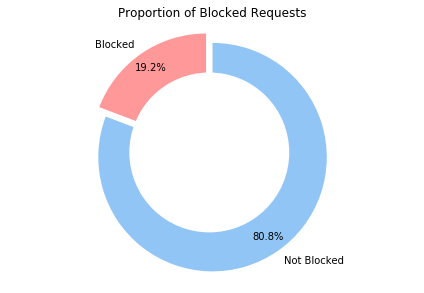

In [3]:
pieplot(ghostery, ublock, duck, brave, abp)

### Looking at all requests

#### **Ghostery vs uBlock vs Brave vs DuckDuckGo**

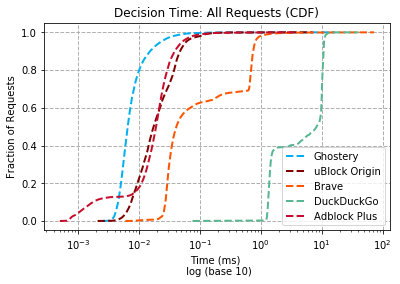

In [4]:
compare_CDF(
    ghostery,
    ublock,
    brave,
    duck,
    abp,
    attr="all",
    log_x=True,
    log_y=False,
    title='Decision Time: All Requests (CDF)'
)

#### Individual Comparisons
##### 1. **Ghostery vs uBlock**

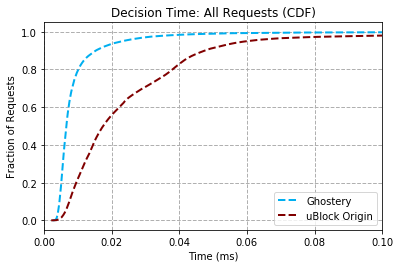

In [5]:
compare_CDF(
    ghostery, 
    ublock, 
    attr="all", 
    log_x=False, 
    log_y=False, 
    xlim=(0, 0.10), 
    title='Decision Time: All Requests (CDF)'
)

##### **2. Ghostery vs AdblockPlus**

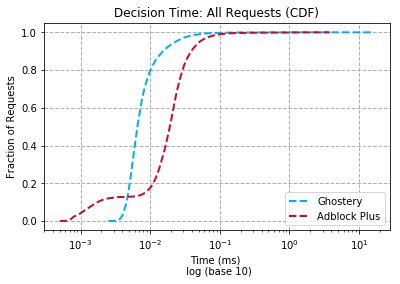

In [6]:
compare_CDF(
    ghostery,
    abp,
    attr="all",
    log_x=True,
    log_y=False,
    title='Decision Time: All Requests (CDF)'
)

### Comparing adblockers on requests that are NOT blocked
**Reminder**: This is the more common case: 82% of the requests are not blocked

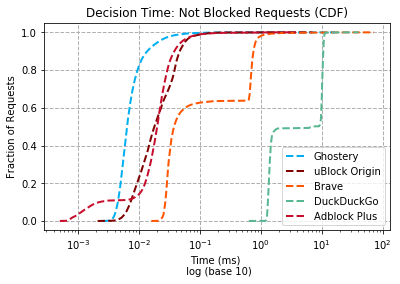

In [7]:
compare_CDF(
    ghostery,
    ublock,
    brave,
    duck,
    abp,
    attr="not_blocked",
    log_x=True,
    log_y=False,
    title='Decision Time: Not Blocked Requests (CDF)'
)

### Comparing adblockers on requests that are blocked

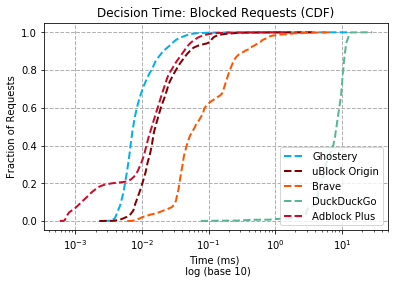

In [8]:
compare_CDF(
    ghostery,
    ublock,
    brave,
    duck,
    abp,
    attr="blocked",
    log_x=True,
    log_y=False,
    title='Decision Time: Blocked Requests (CDF)'
)

### Memory

#### 99th percentile

In [9]:
p99 = pd.DataFrame({
    'request_type': ['_all', 'not_blocked', 'blocked'],
    'ghostery': get_99p(ghostery),
    'ublock': get_99p(ublock),
    'brave': get_99p(brave),
    'duck': get_99p(duck),
    'abp': get_99p(abp),
})

p99['ublock_vs_ghostery'] = p99.ublock / p99.ghostery
p99['brave_vs_ghostery'] = p99.brave / p99.ghostery
p99['duck_vs_ghostery'] = p99.duck / p99.ghostery
p99['abp_vs_ghostery'] = p99.abp / p99.ghostery

In [10]:
p99

,request_type,ghostery,ublock,brave,duck,abp,ublock_vs_ghostery,brave_vs_ghostery,duck_vs_ghostery,abp_vs_ghostery
0,_all,0.049825,0.124101,1.288046,12.084761,0.103083,2.490738,25.851400,242.544124,2.068901
1,not_blocked,0.048555,0.111508,1.269874,11.189538,0.105098,2.296530,26.153311,230.450788,2.164514
2,blocked,0.052412,0.164751,1.468203,13.024691,0.098532,3.143383,28.012726,248.505896,1.879951


#### Medians

In [11]:
medians = pd.DataFrame({
    'request_type': ['_all', 'not_blocked', 'blocked'],
    'ghostery': list(map(lambda x: np.median(x), [ghostery.all.raw, ghostery.not_blocked.raw, ghostery.blocked.raw])),
    'ublock': list(map(lambda x: np.median(x), [ublock.all.raw, ublock.not_blocked.raw, ublock.blocked.raw])),
    'brave': list(map(lambda x: np.median(x), [brave.all.raw, brave.not_blocked.raw, brave.blocked.raw])),
    'duck': list(map(lambda x: np.median(x), [duck.all.raw, duck.not_blocked.raw, duck.blocked.raw])),
    'abp': list(map(lambda x: np.median(x), [abp.all.raw, abp.not_blocked.raw, abp.blocked.raw]))

})


In [12]:
medians['ublock_vs_ghostery'] = medians.ublock / medians.ghostery
medians['brave_vs_ghostery'] = medians.brave / medians.ghostery
medians['duck_vs_ghostery'] = medians.duck / medians.ghostery
medians['abp_vs_ghostery'] = medians.abp / medians.ghostery

In [13]:
medians

,request_type,ghostery,ublock,brave,duck,abp,ublock_vs_ghostery,brave_vs_ghostery,duck_vs_ghostery,abp_vs_ghostery
0,_all,0.006572,0.017472,0.041328,8.270044,0.019164,2.658551,6.288497,1258.375533,2.916007
1,not_blocked,0.006394,0.017992,0.037838,6.780612,0.020016,2.813888,5.917735,1060.464811,3.130435
2,blocked,0.007350,0.015901,0.062427,8.309739,0.014033,2.163469,8.493469,1130.576803,1.909252


In [14]:
for request_type in ['_all', 'not_blocked', 'blocked']:
    print('Request type', request_type)
    print(generate_table(p99, medians, request_type=request_type))

Request type _all

|               | 99% OF REQUESTS              | MEDIAN                       |
| ------------- | ---------------------------- | ---------------------------- |
| **Ghostery**  | **0.050ms**                  | **0.007ms**                  |
| uBlock Origin | 0.124ms (**2.5x slower**)    | 0.017ms (**2.7x slower**)    |
| Adblock Plus  | 0.103ms (**2.1x slower**)    | 0.019ms (**2.9x slower**)    |
| Brave         | 1.288ms (**25.9x slower**)   | 0.041ms (**6.3x slower**)    |
| DuckDuckGo    | 12.085ms (**242.5x slower**) | 8.270ms (**1258.4x slower**) |
    
Request type not_blocked

|               | 99% OF REQUESTS              | MEDIAN                       |
| ------------- | ---------------------------- | ---------------------------- |
| **Ghostery**  | **0.049ms**                  | **0.006ms**                  |
| uBlock Origin | 0.112ms (**2.3x slower**)    | 0.018ms (**2.8x slower**)    |
| Adblock Plus  | 0.105ms (**2.2x slower**)    | 0.020ms (**3.1x slowe

## Serialization and Deserialization timings

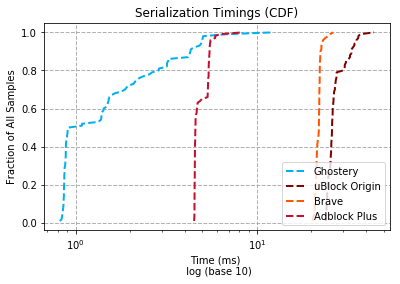

In [15]:
compare_CDF(
    ghostery,
    ublock,
    brave,
    abp,
    attr="serializationTimings",
    log_x=True,
    log_y=False,
    y_label="Fraction of All Samples",
    title='Serialization Timings (CDF)'
)

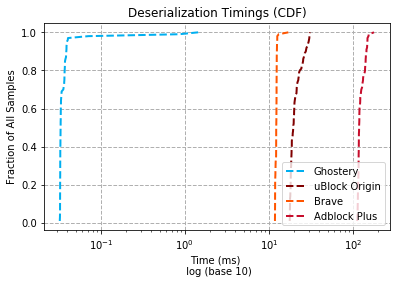

In [16]:
compare_CDF(
    ghostery, 
    ublock, 
    brave, 
    abp, 
    attr="deserializationTimings", 
    log_x=True, 
    log_y=False, 
    y_label="Fraction of All Samples", 
    title='Deserialization Timings (CDF)'
)

In [17]:
def compute_loading_medians(field, *adblockers):
    return pd.DataFrame({
        'adblocker': [adblocker.label for adblocker in adblockers],
        field: [np.median(getattr(adblocker, field).raw) for adblocker in adblockers],
    })

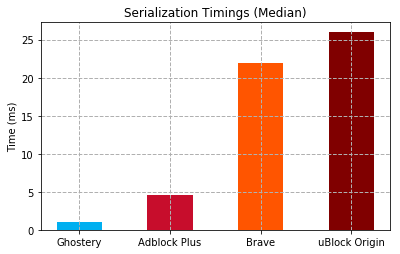

In [18]:
serialization_medians = compute_loading_medians('serializationTimings', ghostery, abp, brave, ublock)
barplot(
    serialization_medians, 
    'serializationTimings',
    title='Serialization Timings (Median)',
    ylabel="Time (ms)", 
    color=[ghostery.color, abp.color, brave.color, ublock.color], 
    save=True
)

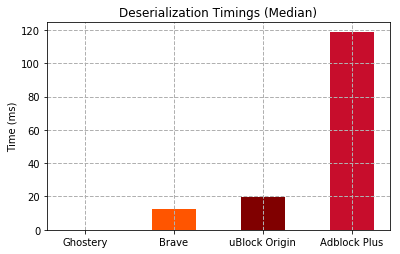

In [19]:
deserialization_medians = compute_loading_medians('deserializationTimings', ghostery, brave, ublock, abp)
barplot( 
    deserialization_medians, 
    'deserializationTimings', 
    ylabel="Time (ms)",
    title='Deserialization Timings (Median)',
    color=[ghostery.color, brave.color, ublock.color, abp.color], 
    save=True
)

In [20]:
deserialization_medians

,adblocker,deserializationTimings
0,Ghostery,0.033173
1,Brave,12.231583
2,uBlock Origin,19.521571
3,Adblock Plus,118.616674


## Serialized Size

In [21]:
size_medians = pd.DataFrame({
    'adblocker': [abp.label, ghostery.label, brave.label, ublock.label],
    'Cache Size': [abp.cacheSize, ghostery.cacheSize, brave.cacheSize, ublock.cacheSize]
})

size_medians['Cache Size'] /= (10**6)

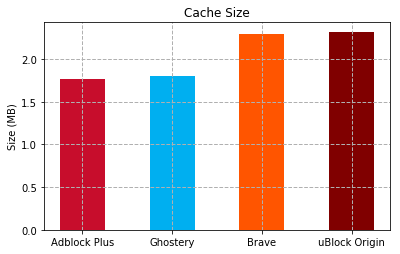

In [22]:
barplot(
    size_medians, 
    'Cache Size', 
    ylabel="Size (MB)", 
    color=[abp.color, ghostery.color, brave.color, ublock.color], 
    save=True
)

### Memory Usage

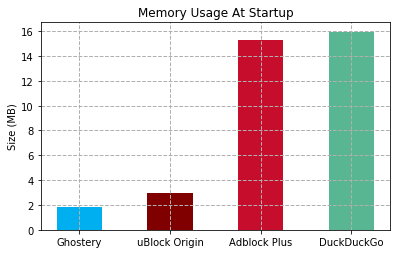

In [23]:
memory_medians = pd.DataFrame({
    'adblocker': [ghostery.label, ublock.label, abp.label, duck.label],
    'Memory Usage at Startup': [1.803, 2.942, 15.292, 15.920]
})


barplot(
    memory_medians, 
    'Memory Usage at Startup', 
    ylabel="Size (MB)", 
    color=[ghostery.color, ublock.color, abp.color, duck.color], 
    save=True
)

### Time to Parse Lists

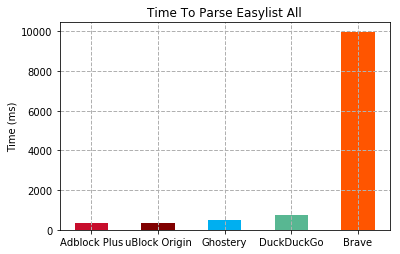

In [24]:
time2parse_medians = pd.DataFrame({
    'adblocker': [abp.label, ublock.label, ghostery.label, duck.label, brave.label],
    'Time to parse Easylist All': [abp.parsingTime, ublock.parsingTime, ghostery.parsingTime, duck.parsingTime, brave.parsingTime]
})

barplot(
    time2parse_medians, 
    'Time to parse Easylist All', 
    ylabel="Time (ms)", 
    color=[abp.color, ublock.color, ghostery.color, duck.color, brave.color], 
    save=True
)

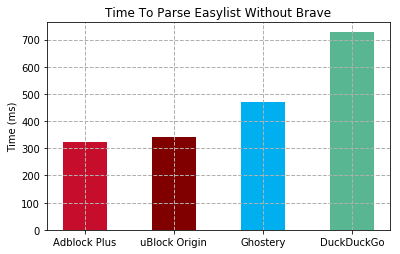

In [25]:
time2parse_medians = pd.DataFrame({
    'adblocker': [abp.label, ublock.label, ghostery.label, duck.label],
    'Time to parse Easylist Without Brave': [abp.parsingTime, ublock.parsingTime, ghostery.parsingTime, duck.parsingTime]
})

barplot(
    time2parse_medians, 
    'Time to parse Easylist Without Brave', 
    ylabel="Time (ms)", 
    color=[abp.color, ublock.color, ghostery.color, duck.color], 
    save=True
)